* ver si conviene usar `generators` (ver proyecto de EEG prediction)
* leer desde timescale db
* diseño de la red "optimizable" (~neuroevolución)


Recursos interesantes:

* https://www.liip.ch/en/blog/time-series-prediction-a-short-comparison-of-best-practices
* https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [8]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
import pickle
import glob

from satlomasproc.configuration import LSTMTrainingScriptConfig

from satlomasproc.data import read_time_series_from_csv
from satlomasproc.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from satlomasproc.model_hyperopt import (
    get_lstm_nnet_opt
)
from satlomasproc.model import (train_val_test_split)


import ipdb

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        #names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [('%s(t-%d)' % (var_name, i)) for var_name in df.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (var_name)) for var_name in df.columns]
        else:
            names += [('%s(t+%d)' % (var_name, i)) for var_name in df.columns]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:

# design network
model = Sequential()
#model.add(LSTM(2*n_hours, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(2*n_hours, input_shape=(n_hours, 1),return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(3*n_hours, return_sequences=True)) 
model.add(Dropout(rate=0.2))
model.add(LSTM(2*n_hours)) 
model.add(Dropout(rate=0.2))
model.add(Dense(1))

#model_loss = 'mae'
model_loss = 'mean_squared_error'

model.compile(loss=model_loss, optimizer='adam')
#model.compile(loss='model_loss', optimizer='adam', metrics=['accuracy'])

# fit network
# que corte despues de no mejorar mucho
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',restore_best_weights=True)
# que use el mejor modelo

checkpoint = ModelCheckpoint(out_model_name, save_best_only=True, monitor='val_loss', mode='min',verbose=2)

history = model.fit(train_X, train_y, epochs=100, validation_data=(val_X, val_y), verbose=1, shuffle=False,callbacks=[checkpoint,early_stopping])
print(model.summary())

with open('history.pickle', 'wb') as file_pi:
    pickle.dump(history, file_pi)


../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3, 4][0.1, 0.8]5_hyperopt_history_2020-03-02_00:27:24.pickle
../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_history_2020-02-27_23:55:00.pickle


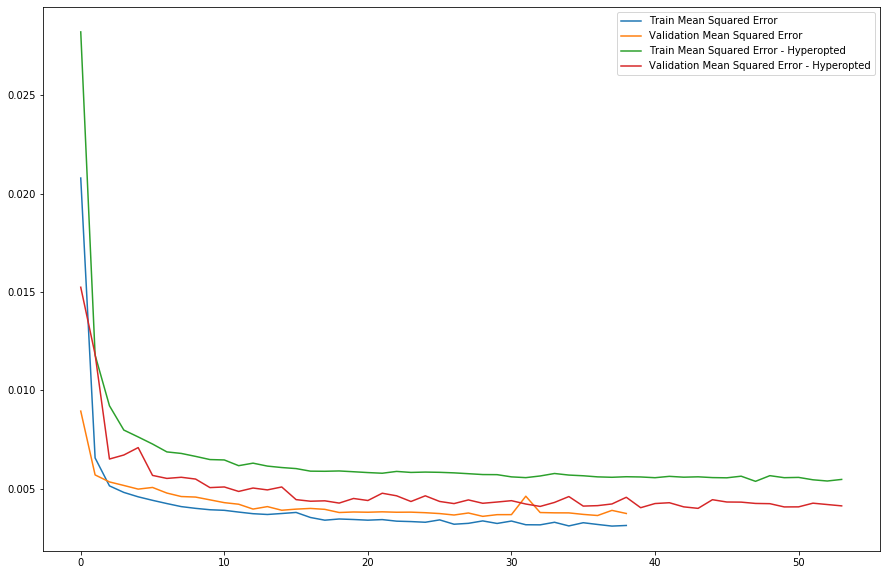

In [10]:
# plot history
read_prev = True

filename_hyperopt_history = glob.glob('../models/*_hyperopt_history_*.pickle')[-1]
filename_history = '../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_history_2020-02-27_23:55:00.pickle'

print(filename_hyperopt_history)
print(filename_history)

if read_prev:
    try:
        del history
    except:
        pass
    with open(filename_history, 'rb') as file_pi:
        history = pickle.load(file_pi)
    try:
        del history_hyper
    except:
        pass
    with open(filename_hyperopt_history, 'rb') as file_pi:
        history_hyper = pickle.load(file_pi)

plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='Train Mean Squared Error')
plt.plot(history.history['val_loss'], label='Validation Mean Squared Error')
plt.plot(history_hyper.history['loss'], label='Train Mean Squared Error - Hyperopted')
plt.plot(history_hyper.history['val_loss'], label='Validation Mean Squared Error - Hyperopted')
plt.legend()
plt.savefig('traininig_curve.png')
plt.show()

In [11]:

out_model_name = glob.glob('../models/*_hyperopt_model_*.hdf5')[-1]
print(out_model_name)
#out_model_name = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_model_2020-02-25_10:13:29.hdf5'
model_hyper = load_model(out_model_name)
print(model_hyper.summary())


../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3, 4][2, 3, 4][0.1, 0.8]5_hyperopt_model_2020-03-02_00:27:24.hdf5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 20)             1760      
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 20)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 10)             1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 10)             840       
__________________________________________________________

In [61]:
layer_idx = 2
model_hyper.layers[layer_idx].input_shape

(None, 3, 9)

In [12]:

out_model_name_simple = '../models/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_model_2020-02-27_23:55:00.hdf5'
model_simple = load_model(out_model_name_simple)
print(model_simple.summary())
model_simple.layers[3].rate

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 10)             480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)               

0.2

In [13]:
# load dataset usando satlomas
config_file = '../config_train_lstm_temp.json'
script_config = LSTMTrainingScriptConfig(config_file)

n_past_steps = script_config.n_past_steps
input_csv = script_config.input_csv

date_col = script_config.date_col
hr_col = script_config.hr_col
target_var = script_config.numeric_var
sensor_var = script_config.sensor_var
sensor = script_config.target_sensor

# read the raw data
input_csv_nb = '../{}'.format(input_csv)
raw_dataset = read_time_series_from_csv(input_csv_nb,date_col,hr_col,target_var,sensor_var)
raw_dataset.head()

# get the time series dataset
time_series_dset = get_interest_variable(raw_dataset,sensor_var,date_col,hr_col,target_var,sensor)
time_series_dset.head()

# get the final dataset
sup_dataset,scaler = get_dataset_from_series(time_series_dset,n_past_steps)
print(scaler)
sup_dataset.head()

# split the dataset in train , test and validation
n_features = time_series_dset.shape[1]
dataset_splits = train_val_test_split(sup_dataset,n_past_steps,n_features,target_var)

train_X = dataset_splits['trainset']['X']
test_X = dataset_splits['testset']['X']

train_y = dataset_splits['trainset']['y']
test_y = dataset_splits['testset']['y']

read dataset of shape (160584, 3)
MinMaxScaler(copy=True, feature_range=(0, 1))
Sampleamos datasets de futuro a pasado
(96347, 5) 96347 (96347,)
(96347, 5, 1) (96347,) (32115, 5, 1) (32115,) (32117, 5, 1) (32117,)


In [14]:
# make a prediction
def make_prediction(model):
#    try:
#        del model
#    except:
#        pass

#    model = model_hyper
    print(model.summary())

    yhat = model.predict(test_X)
    tr_yhat = model.predict(train_X)

    # por que reshapeamos aca?
    test_X_2d = test_X.reshape((test_X.shape[0], n_past_steps*n_features))
    train_X_2d = train_X.reshape((train_X.shape[0], n_past_steps*n_features))
    # invert scaling for forecast
    # test
    # Por que lo que hace es armar una matrix n_samples,6 con una fila por cada datapoint con la primera columna con la prediccion y las otras las features?
    inv_yhat = concatenate((yhat, test_X_2d[:, -1*(n_features-1):]), axis=1)
    # afecta en algo aplicar invers_stransform sobre una sola columna que con tra la matriz?
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # train
    tr_inv_yhat = concatenate((tr_yhat, train_X_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
    tr_inv_yhat = tr_inv_yhat[:,0]

    # invert scaling for actual
    #test
    test_y_2d = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_2d, test_X_2d[:, -1*(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    #train
    train_y_2d = train_y.reshape((len(train_y), 1))
    tr_inv_y = concatenate((train_y_2d, train_y_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_y = scaler.inverse_transform(tr_inv_y)
    tr_inv_y = tr_inv_y[:,0]


    # calculate MAE
    tr_mae = mean_absolute_error(tr_inv_y, tr_inv_yhat)
    print('Train MAE: %.3f' % tr_mae)
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('Test MAE: %.3f' % mae)
    return inv_yhat,inv_y
    
    
predictions_hyper , inv_y = make_prediction(model_hyper)
predictions_simple , inv_y = make_prediction(model_simple)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 20)             1760      
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 20)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 10)             1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 10)             840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 5, 10)            

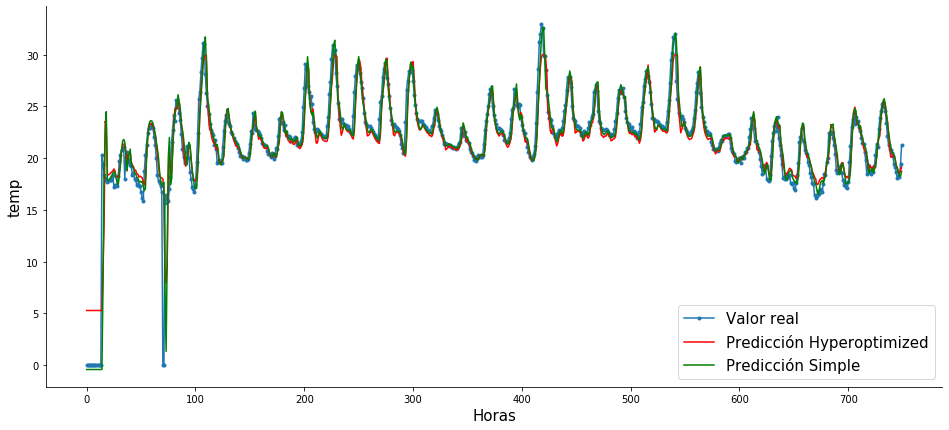

In [15]:
#%matplotlib inline

def plot_predictions(real,hyper,simple):
    inv_y = real
    inv_yhat = hyper
    inv_yhat_simple = simple
    # ploting the actual and prediction together
    total_time_steps = 750
    time_steps=[x for x in range(total_time_steps)]
    plt.figure(figsize=(15,7))

    #plt.plot(time_steps, Y_test[0][:total_time_steps], marker='.', label="actual")
    #plt.plot(time_steps, test_predict[:,0][:total_time_steps], 'r', label="prediction")

    plt.plot(time_steps, inv_y[:total_time_steps], marker='.', label="Valor real")
    plt.plot(time_steps, inv_yhat[:total_time_steps], 'r', label="Predicción Hyperoptimized")
    plt.plot(time_steps, inv_yhat_simple[:total_time_steps], 'g', label="Predicción Simple")

    # plt.tick_params(left=False, labelleft=True) #remove ticks
    #plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel(target_var, size=15)
    plt.xlabel('Horas', size=15)
    plt.legend(fontsize=15)
    plt.savefig('prediction_plot.png')
    plt.show()
    
plot_predictions(inv_y,predictions_hyper,predictions_simple)

In [19]:
results_train_simple_old = pd.read_csv('../results/A620_temp_results_2020-01-08_23:29:54.csv')
results_train_simple_new = pd.read_csv('../results/esp:10_eps:1000_loss:mean_squared_error_opt:adam_pstps:5_sensor:A620_var:temp_basenet:4.4_midnet:4.2_results_2020-02-27_23:55:00.csv')
# TODO add the results of the hyperopt version

full_results = results_train_simple_old.append([results_train_simple_new])
full_results


,base_nnet_config,early_stop_patience,epochs,mid_layers_config,model_loss,optimizer,sensor,target_variable,test_eval_time,test_mae,test_r2,train_eval_time,train_mae,train_r2,train_time,trainset_size
0,"{'last_layer': {'dropout_rate': 0.2, 'mult': 2...",50,1000,"{'dropout_rate': 0.2, 'mult': 2, 'n_layers': 2}",mean_squared_error,adam,A620,temp,3.157078,0.875876,0.837557,9.898352,0.894118,0.869826,6746.712107,96347
0,"{'first_layer': {'mult': 2, 'dropout_rate': 0....",10,1000,"{'n_layers': 2, 'mult': 2, 'dropout_rate': 0.2...",mean_squared_error,adam,A620,temp,3.918331,0.883605,0.839331,12.540939,0.933754,0.873177,2340.151129,96347
